In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 1. Φόρτωση του Citrus Leaves Dataset
dataset, info = tfds.load('citrus_leaves', with_info=True, as_supervised=True)

# Διαχωρισμός σε train και test sets
full_dataset = dataset['train']
train_size = int(0.8 * info.splits['train'].num_examples)  # 80% training
test_size = info.splits['train'].num_examples - train_size  # 20% test

train_data = full_dataset.take(train_size)  # Πρώτα train_size δείγματα
test_data = full_dataset.skip(train_size)  # Τα υπόλοιπα test_size δείγματα

# 2. Προεπεξεργασία και Data Augmentation
def preprocess(image, label):
    """
    Επεξεργασία εικόνων:
    - Resize σε (150, 150)
    - Κανονικοποίηση (0-255 -> 0-1)
    """
    image = tf.image.resize(image, (150, 150)) / 255.0
    return image, label

# Data augmentation generator
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

# Εφαρμογή προεπεξεργασίας και batching
train_data = train_data.map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# 3. Δημιουργία του Μοντέλου με Transfer Learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Παγώνουμε το προεκπαιδευμένο μοντέλο

model = models.Sequential([
    data_augmentation,  # Data Augmentation ως μέρος του pipeline
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout για αποφυγή overfitting
    layers.Dense(4, activation='softmax')  # 4 κατηγορίες: Healthy, Black Spot, Canker, Greening
])

# 4. Συμπύκνωση του Μοντέλου
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 5. Callback για early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# 6. Εκπαίδευση του Μοντέλου
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[early_stopping],  # Σταματάει αν δεν βελτιώνεται το validation loss
    verbose=2
)

# 7. Fine-Tuning του Base Model
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Fine-tuning
fine_tune_history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10,
    callbacks=[early_stopping],  # Σταματάει αν δεν βελτιώνεται το validation loss
    verbose=2
)

# 8. Αξιολόγηση του Μοντέλου
test_loss, test_acc = model.evaluate(test_data, verbose=2)
print(f'\nTest accuracy: {test_acc}')


/var/folders/9_/0tyxd1bx3xvgh39p_jbkksf00000gp/T/ipykernel_1299/1508457967.py:41: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/20


2024-11-17 09:58:22.665969: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


15/15 - 6s - 383ms/step - accuracy: 0.4716 - loss: 1.3181 - val_accuracy: 0.6471 - val_loss: 0.8528
Epoch 2/20
15/15 - 2s - 143ms/step - accuracy: 0.6379 - loss: 0.8291 - val_accuracy: 0.7479 - val_loss: 0.6546
Epoch 3/20
15/15 - 2s - 142ms/step - accuracy: 0.6716 - loss: 0.7774 - val_accuracy: 0.6975 - val_loss: 0.7168
Epoch 4/20
15/15 - 2s - 142ms/step - accuracy: 0.7389 - loss: 0.6617 - val_accuracy: 0.8235 - val_loss: 0.5218
Epoch 5/20
15/15 - 2s - 141ms/step - accuracy: 0.7389 - loss: 0.6417 - val_accuracy: 0.7899 - val_loss: 0.5622
Epoch 6/20
15/15 - 2s - 141ms/step - accuracy: 0.7326 - loss: 0.6591 - val_accuracy: 0.7563 - val_loss: 0.5938
Epoch 7/20
15/15 - 2s - 143ms/step - accuracy: 0.7789 - loss: 0.5832 - val_accuracy: 0.7815 - val_loss: 0.5474
Epoch 8/20
15/15 - 2s - 144ms/step - accuracy: 0.7747 - loss: 0.5336 - val_accuracy: 0.8235 - val_loss: 0.4781
Epoch 9/20
15/15 - 2s - 144ms/step - accuracy: 0.8147 - loss: 0.4871 - val_accuracy: 0.8319 - val_loss: 0.4581
Epoch 10/20


2024-11-17 10:02:02.276968: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


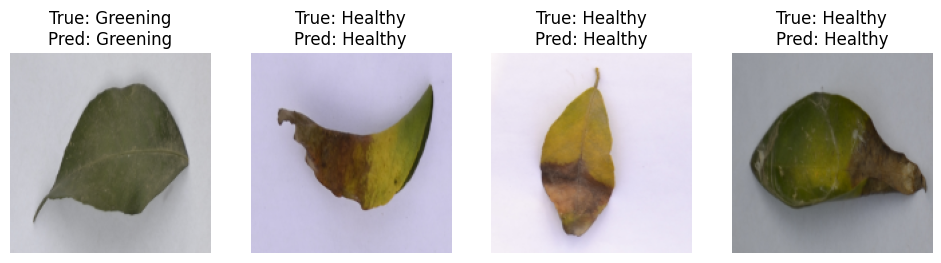

In [4]:
# 9. Συνάρτηση για Εμφάνιση Προβλέψεων
def show_predictions(dataset, model, n=5):
    """
    Εμφάνιση n εικόνων από το test set με τις προβλέψεις του μοντέλου.
    """
    class_names = ["Healthy", "Black Spot", "Canker", "Greening"]
    plt.figure(figsize=(15, 15))

    for i, (image_batch, label_batch) in enumerate(dataset.take(n)):
        for j in range(len(image_batch)):  # Για κάθε εικόνα στο batch
            img = image_batch[j].numpy()
            prediction = model.predict(img[None, ...], verbose=0)  # Προσθήκη batch axis
            predicted_label = class_names[tf.argmax(prediction[0]).numpy()]
            true_label = class_names[label_batch[j].numpy()]

            # Εμφάνιση της εικόνας
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {predicted_label}")
            plt.axis('off')
    plt.show()

# 10. Εμφάνιση Προβλέψεων
show_predictions(test_data, model, n=5)